# Goal
This notebook will show how to map data using the MapMyCells data products released with the HMBA consensus Basal Ganglia taxonomy.

[Original Notebook here](https://github.com/AllenInstitute/HMBA_BasalGanglia_Consensus_Taxonomy/blob/main/examples/using_MapMyCells_data.ipynb)

# Install MapMyCell dependencies
We are going to start by installing the `cell_type_mapper` (actual backend for MapMyCells) and `abc_atlas_access` (convenient download of other data provided by the AllenInstitute) libraries.
```bash
uv add "cell_type_mapper@git+https://github.com/alleninstitute/cell_type_mapper.git@rc/v1.5.2"
uv add "abc_atlas_access[notebooks] @ git+https://github.com/alleninstitute/abc_atlas_access.git"
```

# Dowload mapping files for basal ganglia

To run MapMyCells, you need two supporting data files: 
- [an HDF5 file](https://github.com/AllenInstitute/cell_type_mapper/blob/main/docs/input_data_files/precomputed_stats_file.md) which defines your taxonomy and the average gene expression profiles of the taxons there in
- [lookup table of marker genes](https://github.com/AllenInstitute/cell_type_mapper/blob/main/docs/input_data_files/marker_gene_lookup.md) for your taxonomy. 

Let's download those two files for the **human** basal ganglia data. 
Refer back [to the main page](https://github.com/AllenInstitute/HMBA_BasalGanglia_Consensus_Taxonomy/blob/main/index.md#cell-type-mapping-with-mapmycells) for the locations of the relevant files for all three species (human, marmoset, and macaque).

```bash
wget https://released-taxonomies-802451596237-us-west-2.s3.us-west-2.amazonaws.com/HMBA/BasalGanglia/BICAN_05072025_pre-print_release/MapMyCells/Human.precomputed_stats.20250507.h5
wget https://released-taxonomies-802451596237-us-west-2.s3.us-west-2.amazonaws.com/HMBA/BasalGanglia/BICAN_05072025_pre-print_release/MapMyCells/Human.query_markers.20250507.json
```

---

In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from pathlib import Path
import os
from dotenv import load_dotenv; load_dotenv()
import ipynbname
import shutil

# MUST BE FIRST - before any imports from cell_type_mapper --> error if FromSpecifiedMarkersRunner run wiht GPU
os.environ['CUDA_VISIBLE_DEVICES'] = ''

import cell_type_mapper
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache
from cell_type_mapper.cli.from_specified_markers import FromSpecifiedMarkersRunner

# Hyperparamyters
BASE_PATH = os.getenv("BASE_PATH_FOR_SAVING")
DISEASE_TYPE = "diseased" # diseased / healthy
SAMPLE_ID = "recon_241105"
BCL = "FAKE_BCL"#"240805_SL-EXD_0328_B22FKKYLT4"
LIBRARY = "FAKE_LIBRARY"#"SI-TT-H3"

# Prepare Query data

Your query data must be:
- **Format**: `.h5ad` file (AnnData format)
- **Structure**: 
  - `X` layer with **RAW** gene expression data (cells × genes)
  - `obs` with cell metadata
  - `var` with gene names, **Ensembl IDs** for MapMyCells-supported taxonomies

In [3]:
QUERY_PATH = f"{BASE_PATH}/{DISEASE_TYPE}/{SAMPLE_ID}/{BCL}/{LIBRARY}/adata/raw_adata.h5ad"

# paths to files where mapping output will be written
json_dst_path = str(Path(QUERY_PATH).parent.parent / "map_my_cell" / "mapping.json")
csv_dst_path = str(Path(QUERY_PATH).parent.parent / "map_my_cell" / "mapping.csv")

# saving adata path
adata_labelled_path = str(Path(QUERY_PATH).parent / "labelled_adata.h5ad")

# FIXED (always mappign againf basal ganglia)
query_marker_path = os.getenv("ALLEN_ATLAS_BG_MMC_MARKER_JSON") # the lookup table of marker genes which we downloaded from S3
precomputed_path = os.getenv("ALLEN_ATLAS_BG_MMC_STAT_H5") # the human-specific precomputed stats file which we downloaded from S3

# Run Mapping

Now we will actually [perform the mapping](https://github.com/AllenInstitute/cell_type_mapper/blob/main/docs/mapping_cells.md).

In [4]:
config = {
    # output paths
    "query_path": QUERY_PATH,
    "extended_result_path": json_dst_path,
    "csv_result_path": csv_dst_path,
    "verbose_csv": True,

    # inout paths
    "query_markers": {
       "serialized_lookup": query_marker_path
    },
    "precomputed_stats": {
        "path": precomputed_path
    },

    "type_assignment": {
        "n_processors": 8,
        "normalization": "raw", # Use raw counts (not normalized)
        "bootstrap_factor": 0.5,
        "bootstrap_iteration": 100
    }
}

In [5]:
runner = FromSpecifiedMarkersRunner(
    args=[],
    input_data=config
)
runner.run()
print("Done!")

=== Running Hierarchical Mapping 1.5.2 with config ===
{
  "query_markers": {
    "log_level": "ERROR",
    "serialized_lookup": "/home/gdallagl/myworkdir/XDP/data/AllenAtlas/BGT_human_20250507/Human.query_markers.20250507.json",
    "collapse_markers": false
  },
  "cloud_safe": false,
  "map_to_ensembl": false,
  "precomputed_stats": {
    "path": "/home/gdallagl/myworkdir/XDP/data/AllenAtlas/BGT_human_20250507/Human.precomputed_stats.20250507.h5",
    "log_level": "ERROR"
  },
  "csv_result_path": "/home/gdallagl/myworkdir/data/XDP/diseased/recon_241105/FAKE_BCL/FAKE_LIBRARY/map_my_cell/mapping.csv",
  "log_level": "ERROR",
  "obsm_key": null,
  "extended_result_path": "/home/gdallagl/myworkdir/data/XDP/diseased/recon_241105/FAKE_BCL/FAKE_LIBRARY/map_my_cell/mapping.json",
  "drop_level": null,
  "hdf5_result_path": null,
  "type_assignment": {
    "chunk_size": 10000,
    "n_processors": 8,
    "min_markers": 10,
    "log_level": "ERROR",
    "rng_seed": 11235813,
    "bootstrap_it

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/cell_type_mapper/cli/cli_log.py:73: UserWarning: numpy's internal parallelization is enabled. This could cause independent worker processes to compete for resources, degrading performance. We recommend setting the following environment variables to '1' to improve performance
{
  "NUMEXPR_NUM_THREADS": "",
  "MKL_NUM_THREADS": "",
  "OMP_NUM_THREADS": ""
}
  warnings.warn(msg)
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/cell_type_mapper/cli/cli_log.py:104: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  self.env(f"anndata version: {anndata.__version__}")
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/cell_type_mapper/taxonomy/utils.py:253: UserWarning: This taxonomy has no mapping from leaf_node -> rows in the cell by gene matrix
  warnings.warn("This taxonomy has no mapping from leaf_node -> rows "
/home/gdallagl/myworkdir/XDP/.venv/lib

BENCHMARK: spent 1.4620e-01 seconds creating query marker cache
Running CPU implementation of type assignment.
90000 of 129301 cells in 8.92e+00 min; predict 3.89e+00 min of 1.28e+01 min left
BENCHMARK: spent 6.5608e+02 seconds assigning cell types
Writing marker genes to output file
MAPPING FROM SPECIFIED MARKERS RAN SUCCESSFULLY
CLEANING UP
Done!


# Output of mapping file

The results of our mapping are now in two files: the csv file pointed to by `csv_dst_path` and the JSON file pointed to by `json_dst_path`. Dedicated documentation of the the contents of the mapping output [can be found here.](https://github.com/AllenInstitute/cell_type_mapper/blob/main/docs/output.md)

## CSV output file

The CSV file is effectively just a dataframe. For every cell at every taxonomy level, you have its assigned cell type (both as a guaranteed unique "label" and a more human readable "name") along with quality metrics assessing the confidence in the mapping (see the detailed documentation above).

In [6]:
mapping_csv = pd.read_csv(csv_dst_path, comment='#')
mapping_csv = mapping_csv.set_index("cell_id")

display(mapping_csv)

,Neighborhood_label,Neighborhood_name,Neighborhood_bootstrapping_probability,Neighborhood_aggregate_probability,Neighborhood_correlation_coefficient,Class_label,Class_name,Class_bootstrapping_probability,Class_aggregate_probability,Class_correlation_coefficient,...,Group_name,Group_bootstrapping_probability,Group_aggregate_probability,Group_correlation_coefficient,Cluster_label,Cluster_name,Cluster_alias,Cluster_bootstrapping_probability,Cluster_aggregate_probability,Cluster_correlation_coefficient
cell_id,,,,,,,,,,,,,,,,,,,,,
RECON_rxn1__AAACCAGCAATGCGGG-1,CS20250428_NEIGH_0002,Subpallium GABA,1.0,1.0,0.6789,CS20250428_CLASS_0003,CN LGE GABA,1.00,1.00,0.6416,...,STRv D2 MSN,0.91,0.910,0.5422,CS20250428_CLUST_0562,Human-560,Human-560,0.78,0.7098,0.5515
RECON_rxn1__AAACCATTCATGGACC-1,CS20250428_NEIGH_0002,Subpallium GABA,1.0,1.0,0.6428,CS20250428_CLASS_0005,CN MGE GABA,1.00,1.00,0.6321,...,STR TAC3-PLPP4 GABA,0.71,0.710,0.6100,CS20250428_CLUST_0410,Human-21,Human-21,0.99,0.7029,0.2005
RECON_rxn1__AAACCATTCCATGGGT-1,CS20250428_NEIGH_0002,Subpallium GABA,1.0,1.0,0.7604,CS20250428_CLASS_0003,CN LGE GABA,1.00,1.00,0.7394,...,STRv D1 NUDAP MSN,1.00,1.000,0.6512,CS20250428_CLUST_0516,Human-484,Human-484,0.97,0.9700,0.5625
RECON_rxn1__AAACCATTCCCTACCA-1,CS20250428_NEIGH_0002,Subpallium GABA,1.0,1.0,0.7030,CS20250428_CLASS_0003,CN LGE GABA,1.00,1.00,0.6443,...,STRv D2 MSN,1.00,0.980,0.4717,CS20250428_CLUST_0553,Human-340,Human-340,0.52,0.5096,0.3996
RECON_rxn1__AAACCATTCGCATCAA-1,CS20250428_NEIGH_0002,Subpallium GABA,1.0,1.0,0.6074,CS20250428_CLASS_0006,F M GABA,1.00,1.00,0.5663,...,ZI-HTH GABA,0.73,0.730,0.3901,CS20250428_CLUST_0356,Human-521_1,Human-521_1,1.00,0.7300,0.3901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RECON_rxn8__GTTGCGTAGAGGCCAA-1,CS20250428_NEIGH_0001,Nonneuron,1.0,1.0,0.5936,CS20250428_CLASS_0011,Vascular,1.00,1.00,0.6615,...,Pericyte,1.00,0.980,0.4712,CS20250428_CLUST_0240,Human-271,Human-271,0.48,0.4704,0.3508
RECON_rxn8__GTTGCTTTCCCCATTG-1,CS20250428_NEIGH_0001,Nonneuron,1.0,1.0,0.3245,CS20250428_CLASS_0011,Vascular,0.91,0.91,0.2835,...,Endo,1.00,0.910,0.4309,CS20250428_CLUST_0177,Human-78,Human-78,0.77,0.7007,0.3211
RECON_rxn8__GTTGCTTTCCGCCGTT-1,CS20250428_NEIGH_0001,Nonneuron,1.0,1.0,0.6718,CS20250428_CLASS_0011,Vascular,1.00,1.00,0.7187,...,Pericyte,1.00,0.770,0.5700,CS20250428_CLUST_0240,Human-271,Human-271,1.00,0.7700,0.4822


# Add Metadata to adata and Save

In [7]:
# Read adata
query_adata = sc.read_h5ad(QUERY_PATH)

# Merge metadata
query_adata.obs = query_adata.obs.join(mapping_csv, how="left")
display(query_adata.obs)

# save 
query_adata.write(adata_labelled_path)


n_cells_original = len(query_adata.obs)
n_cells_mapped = mapping_csv.index.nunique()
print(f"Original cells: {n_cells_original}")
print(f"Mapped cells: {n_cells_mapped}")
assert n_cells_original == n_cells_mapped, "Mapping incomplete!"

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,total_counts,n_genes,logumi,pct_counts_mt,seurat_clusters,x,y,library,cell_class,cell_subclass,...,Group_name,Group_bootstrapping_probability,Group_aggregate_probability,Group_correlation_coefficient,Cluster_label,Cluster_name,Cluster_alias,Cluster_bootstrapping_probability,Cluster_aggregate_probability,Cluster_correlation_coefficient
RECON_rxn1__AAACCAGCAATGCGGG-1,22606,5374,4.354243,0.185791,6,3196.657380,10435.337363,RECON_rxn1,neuron,D2_matrix,...,STRv D2 MSN,0.91,0.910,0.5422,CS20250428_CLUST_0562,Human-560,Human-560,0.78,0.7098,0.5515
RECON_rxn1__AAACCATTCATGGACC-1,17421,5813,4.241098,0.453476,28,11946.064911,15601.603753,RECON_rxn1,neuron,interneuron_4,...,STR TAC3-PLPP4 GABA,0.71,0.710,0.6100,CS20250428_CLUST_0410,Human-21,Human-21,0.99,0.7029,0.2005
RECON_rxn1__AAACCATTCCATGGGT-1,27547,6692,4.440090,0.148837,15,NaN,NaN,RECON_rxn1,neuron,eSPN_D1,...,STRv D1 NUDAP MSN,1.00,1.000,0.6512,CS20250428_CLUST_0516,Human-484,Human-484,0.97,0.9700,0.5625
RECON_rxn1__AAACCATTCCCTACCA-1,11514,4058,4.061264,0.243182,11,NaN,NaN,RECON_rxn1,neuron,D2_matrix,...,STRv D2 MSN,1.00,0.980,0.4717,CS20250428_CLUST_0553,Human-340,Human-340,0.52,0.5096,0.3996
RECON_rxn1__AAACCATTCGCATCAA-1,50478,8394,4.703111,0.530924,25,15601.875356,15942.359802,RECON_rxn1,neuron,interneuron_1,...,ZI-HTH GABA,0.73,0.730,0.3901,CS20250428_CLUST_0356,Human-521_1,Human-521_1,1.00,0.7300,0.3901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RECON_rxn8__GTTGCGTAGAGGCCAA-1,4543,2510,3.657438,1.166630,16,11067.522331,876.735952,RECON_rxn8,endothelial,endothelial,...,Pericyte,1.00,0.980,0.4712,CS20250428_CLUST_0240,Human-271,Human-271,0.48,0.4704,0.3508
RECON_rxn8__GTTGCTTTCCCCATTG-1,1724,1150,3.236789,2.552204,20,9408.582546,10774.540729,RECON_rxn8,endothelial,endothelial,...,Endo,1.00,0.910,0.4309,CS20250428_CLUST_0177,Human-78,Human-78,0.77,0.7007,0.3211
RECON_rxn8__GTTGCTTTCCGCCGTT-1,13713,4719,4.137164,0.590680,16,12939.548983,17749.210304,RECON_rxn8,endothelial,endothelial,...,Pericyte,1.00,0.770,0.5700,CS20250428_CLUST_0240,Human-271,Human-271,1.00,0.7700,0.4822
RECON_rxn8__GTTGGTCAGGCATCGT-1,4515,2573,3.654754,1.173865,16,13743.409449,16390.131370,RECON_rxn8,endothelial,endothelial,...,Pericyte,1.00,0.590,0.4030,CS20250428_CLUST_0240,Human-271,Human-271,0.77,0.4543,0.3804


Original cells: 129301
Mapped cells: 129301


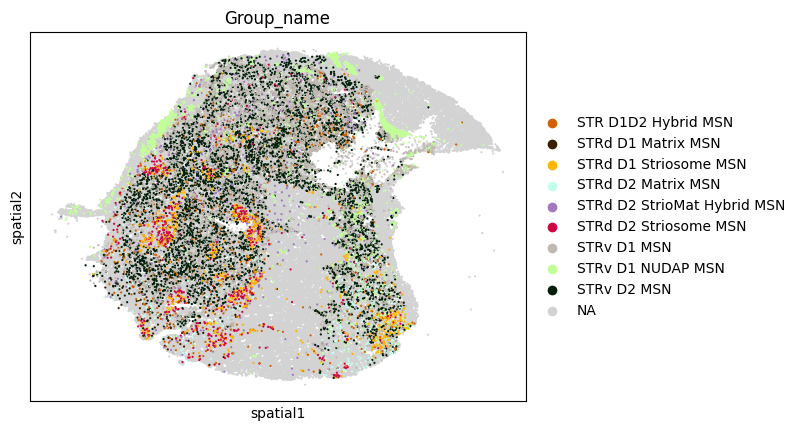

In [19]:
sc.pl.embedding(query_adata, basis="spatial",  color="Group_name", 
                groups=["STRd D1 Matrix MSN", "STRd D1 Striosome MSN", "STRd D2 Matrix MSN", "STRd D2 Striosome MSN", "STRd D2 StrioMat Hybrid MSN", "STRv D1 MSN", "STRv D2 MSN", "STRv D1 NUDAP MSN", "STR D1D2 Hybrid MSN"],
                size=10
)

# Save Notebook

In [20]:
# Get the notebook path
notebook_path = str(ipynbname.path())
print(f"Current notebook: {notebook_path}")

# Save it
base_name = os.path.basename(notebook_path).replace('.ipynb', '')  # Remove .ipynb
saving_path = f"{BASE_PATH}/{DISEASE_TYPE}/{SAMPLE_ID}/notebooks/{base_name}_{BCL}_{LIBRARY}.ipynb"
print(f"Saved to {saving_path}")

print("\n   Press Ctrl+S")

Current notebook: /home/gdallagl/myworkdir/XDP/script/single_sample_analysis/02_labelling_MapMyCells.ipynb
Saved to /home/gdallagl/myworkdir/data/XDP/diseased/recon_241105/notebooks/02_labelling_MapMyCells_FAKE_BCL_FAKE_LIBRARY.ipynb

   Press Ctrl+S


In [21]:
shutil.copy(notebook_path, saving_path)

'/home/gdallagl/myworkdir/data/XDP/diseased/recon_241105/notebooks/02_labelling_MapMyCells_FAKE_BCL_FAKE_LIBRARY.ipynb'

---
---
---

## Optional: JSON output file

The JSON output contains everything in the CSV file, along with helpful metadata about your mapping run as [documented here](https://github.com/AllenInstitute/cell_type_mapper/blob/main/docs/output.md#json-output-file).

In [ ]:
# with open(json_dst_path, 'rb') as src:
#     mapping_json = json.load(src)

For instance, to see the configuration parameters corresponding to your mapping run, you can look at

In [ ]:
# print(json.dumps(mapping_json['config'], indent=2))

The actual cell type assignments are stored as a list under `'results'` as in

In [ ]:
# print(json.dumps(mapping_json['results'][0], indent=2))

One complication is that the cell type assignments are only referred to by their unique machine-readable labels in this file. Fortunately, the cell type taxonomy, along with the mapping between machine- and human-readable cell type labels is also provided in this file. The `TaxonomyTree` class provides a helpful interface with that data.

In [ ]:
# from cell_type_mapper.taxonomy.taxonomy_tree import TaxonomyTree

In [ ]:
# taxonomy = TaxonomyTree(data=mapping_json['taxonomy_tree'])

In [ ]:
# taxonomy.label_to_name(level='CCN20250428_LEVEL_3', label='CS20250428_GROUP_0025')